# 국제 뉴스 api 가져오기
- https://newsapi.org/docs/endpoints/top-headlines

In [362]:
import datetime
import requests 
import pandas as pd

# 현재날짜
current_time = datetime.datetime.now()
one_day_ago = current_time - datetime.timedelta(days=1)
formatted_current_time = current_time.strftime('%Y-%m-%d-')
formatted_one_day_ago = one_day_ago.strftime('%Y-%m-%d')

key = "d9a0c8b871994b6b95e507879e9f9ef6"
# search = 'economics'
# headlines_url = f'https://newsapi.org/v2/everything?q={search}&apiKey={key}&searchIn=title&from={formatted_one_day_ago}&to={formatted_current_time}&language=en&sortBy=relevancy&page=1'
category = 'technology'
headlines_url = f'https://newsapi.org/v2/top-headlines?country=us&category={category}&apiKey={key}&pageSize=100'
result = requests.get(headlines_url)
result.status_code

articles = result.json()['articles']
filtered_data = [{key:value for key, value in art.items() if key!='source'} for art in articles]
source_name = [a['source']['name'] for a in articles]
df_news = pd.DataFrame(filtered_data)
df_news['source_name'] = source_name
df_news.dropna(inplace=True)

df_news.shape


(62, 8)

# 🌟🌟🌟🌟🌟df_news -> mysql에 바로 넣기
mysql에서 rawdata 불러와서 텍스트 분석 후 또 mysql에 넣기

## 텍스트 분석

### 형태소 분석

In [363]:
import re
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import konlpy
import spacy
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk import pos_tag

# nltk.download('punkt')
# nltk.download('averaged_perceptron_tagger')


df_news['replace'] = df_news['title'].apply(lambda x: re.sub(r'[^a-zA-Z]', ' ', x))

# spaCy 모델 로드
nlp = spacy.load('en_core_web_sm')

# 'replace' 열의 각 문장에서 원형 추출
def extract_lemmas(text):
    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)

df_news['lemmas'] = df_news['replace'].apply(extract_lemmas)
df_news['lemmas'] = df_news['lemmas'].str.lower()



def extract_nouns(text):
    tokens = word_tokenize(text)  # 문장을 단어로 토큰화
    tagged = pos_tag(tokens)  # 품사 태깅
    nouns = [word for word, tag in tagged if tag.startswith('N')]  # 명사(NN*)만 추출
    return ' '.join(nouns)

df_news['nouns'] = df_news['lemmas'].apply(extract_nouns)





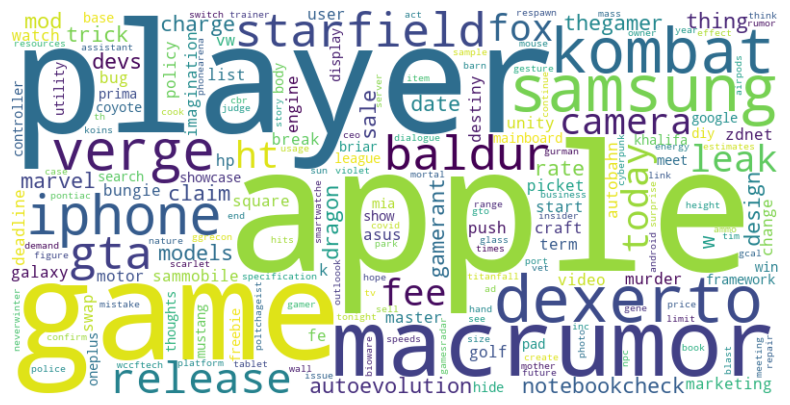

In [417]:
stop_words = ['s','net','review','life','news','age','trends','gate','nothing','ss','tech','i','home','man','z']
all_text  = ' '.join(df_news['nouns'])


# Word Cloud 생성
wordcloud = WordCloud(width=800, height=400, background_color='white',stopwords=stop_words).generate(all_text)

# Word Cloud 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [453]:
from collections import Counter
word_freq = Counter(all_text.split()).most_common()
lst = [i for i in word_freq if i[0] not in stop_words]
keyword_lst = [keyword[0] for keyword in lst[:10]]
keyword_lst

['apple',
 'player',
 'macrumor',
 'samsung',
 'game',
 'dexerto',
 'kombat',
 'iphone',
 'verge',
 'starfield']

In [452]:
# 어떤 키워드가 'df_news['nouns']' 열에 있는지 확인하고 해당 행의 'title'을 출력
for keyword in keyword_lst:
    filtered_df = df_news[df_news['nouns'].apply(lambda x: any(k in x for k in keyword_lst))]

filtered_df

,author,title,description,url,urlToImage,publishedAt,content,source_name,replace,lemmas,nouns
0,Adrian Kingsley-Hughes,Mastering the iPhone 15 Pro camera: Here's wha...,The iPhone 15 Pro is packed with high-end came...,https://www.zdnet.com/article/mastering-the-ip...,https://www.zdnet.com/a/img/resize/e7e8e712ea2...,2023-09-18T04:46:37Z,Jason Hiner/ZDNET\r\nApple put a lot of its fo...,ZDNet,Mastering the iPhone Pro camera Here s wha...,master the iphone pro camera here s what...,master iphone camera apple s marketing term zdnet
1,"SamMobile, Asif Iqbal Shaik","Samsung Galaxy S23 FE video leaks, leaving not...",Samsung will launch one more Galaxy S23 series...,https://www.sammobile.com/news/galaxy-s23-fe-l...,https://www.sammobile.com/wp-content/uploads/2...,2023-09-18T04:43:00Z,Samsung will launch one more Galaxy S23 series...,SamMobile,Samsung Galaxy S FE video leaks leaving not...,samsung galaxy s fe video leak leave noth...,samsung galaxy s fe video leak nothing imagina...
5,Liam Ho,Destiny 2 players stoked Bungie still hasn’t f...,Destiny 2 players have been heaping praise on ...,https://www.dexerto.com/destiny/destiny-2-play...,https://editors.dexerto.com/wp-content/uploads...,2023-09-18T01:24:14Z,Destiny 2 players have been heaping praise on ...,Dexerto,Destiny players stoked Bungie still hasn t f...,destiny player stoke bungie still hasn t fi...,destiny player bungie game break craft bug dex...
6,HT Tech,iPhone users to get iOS 17 starting today! Wil...,iOS 17 will finally be released to iPhone user...,https://tech.hindustantimes.com/mobile/news/ip...,https://images.hindustantimes.com/tech/img/202...,2023-09-18T01:09:42Z,iOS 17 update: Ever since Apple debuted its ne...,Hindustan Times,iPhone users to get iOS starting today Wil...,iphone user to get ios start today will ...,iphone user start today list ht tech
15,Shawn Robinson,How to Complete Second Thoughts in Starfield -...,Having second thoughts about your sanity while...,https://primagames.com/tips/how-to-complete-se...,https://primagames.com/wp-content/uploads/2023...,2023-09-17T21:48:53Z,Most of the missions you’ll find in Starfield ...,Primagames.com,How to Complete Second Thoughts in Starfield ...,how to complete second thoughts in starfield ...,thoughts prima games
16,The Kim Komando Show,"20 Google search tricks, hidden utilities, gam...",Learn more about the most popular search engin...,https://www.foxnews.com/tech/google-search-tri...,https://static.foxnews.com/foxnews.com/content...,2023-09-17T20:38:00Z,Remember when talking to yourself got you weir...,Fox News,Google search tricks hidden utilities gam...,google search trick hide utility game ...,google search trick hide utility game freebie ...
19,Philip Trahan,Pokemon Scarlet & Violet trainer finds handy t...,A Pokemon Scarlet & Violet trainer has shared ...,https://www.dexerto.com/gaming/pokemon-scarlet...,https://editors.dexerto.com/wp-content/uploads...,2023-09-17T19:26:56Z,A Pokemon Scarlet &amp; Violet trainer has sha...,Dexerto,Pokemon Scarlet Violet trainer finds handy t...,pokemon scarlet violet trainer find handy t...,scarlet violet trainer trick poltchageist dexerto
20,Jason Aten,I Can't Stop Thinking About How Awkward Apple'...,The Apple commercial with Octavia Spencer and ...,https://www.inc.com/jason-aten/i-cant-stop-thi...,"https://img-cdn.inc.com/image/upload/w_1024,h_...",2023-09-17T19:25:34Z,"If you watched new Apple's iPhone keynote, the...",Inc.,I Can t Stop Thinking About How Awkward Apple ...,i can t stop think about how awkward apple s ...,i think apple s mother nature ad figure inc
21,Chris Person,The Home Assistant Green is here to make the m...,Home Assistant is celebrating its 10th birthda...,https://www.theverge.com/23875557/home-assista...,https://cdn.vox-cdn.com/thumbor/Nr7DrSS8OCT1qw...,2023-09-17T19:00:00Z,The Home Assistant Green is here to make the m...,The Verge,The Home Assistant Green is here to make the m...,the home assistant green be here to make the m...,home ass

In [448]:
for i in filtered_df['url']:
    print(i)

https://www.zdnet.com/article/mastering-the-iphone-15-pro-camera-heres-what-apples-marketing-terms-actually-mean/
https://www.sammobile.com/news/galaxy-s23-fe-leak-design-all-angles/
https://www.dexerto.com/destiny/destiny-2-players-stoked-bungie-still-hasnt-fixed-game-breaking-crafted-weapons-bug-2297361/
https://tech.hindustantimes.com/mobile/news/iphone-users-to-get-ios-17-starting-today-will-yours-get-it-check-full-list-71694999217782.html
https://primagames.com/tips/how-to-complete-second-thoughts-in-starfield
https://www.foxnews.com/tech/google-search-tricks-hidden-utilities-games-freebies
https://www.dexerto.com/gaming/pokemon-scarlet-violet-trainer-finds-handy-trick-to-find-authentic-poltchageist-2297254/
https://www.inc.com/jason-aten/i-cant-stop-thinking-about-how-awkward-apples-mother-nature-ad-was-i-finally-figured-out-why.html
https://www.theverge.com/23875557/home-assistant-green-announcement-price-specs-ten-year-anniversary
https://wccftech.com/starfield-mods-increase-sh

In [471]:
content = filtered_df.to_html(escape=False)
content = content.replace('<table border="1" class="dataframe">', '<table border="0" class="dataframe" bgcolor=black cellpadding=1 cellspacing=1><tr><td><table border="0" class="dataframe" bgcolor=black>')
content = content.replace('</table>', '</table> </td></tr></table>')
content = content.replace('<td>','<td bgcolor=white>')
content = content.replace('<th>','<th bgcolor=#e5e5e5>')

In [473]:
#-*- coding: utf-8 -*-
def send_mail():
    import smtplib
    from email.mime.text import MIMEText
    from email.header import Header

    html_content = rf"""
    <html>
    <head></head>
    <body>
    <h1>Hello하하하하, this is an HTML email</h1>
    <p>This email contains HTML content.</p>
    </body>
    </html>

    {content}
    """


    msg = MIMEText(f'{html_content}','html','utf-8')                   # 메일 본문 첨부
    msg['Subject'] = Header('메일 제목','utf-8') # 메일 제목 첨부
    msg['From'] = 'brownpuka94@gmail.com'       # 송신 메일
    msg['To'] = 'brownpuka94@naver.com'        # 수신 메일
    with smtplib.SMTP_SSL('smtp.gmail.com') as smtp: # (*)
        smtp.login('brownpuka94@gmail.com','zzjx dlve yqrb vehx')           # (**)
        smtp.send_message(msg)

    print('메일 전송 중')

https://meir.tistory.com/113

In [474]:
import schedule
import time

# schedule.every().day.at('19:13').do('함수')
schedule.every(11).seconds.do(send_mail)

while True:
    schedule.run_pending()
    time.sleep(1)

메일 전송 중
메일 전송 중


KeyboardInterrupt: 

In [470]:
# import smtplib
# from email.mime.text import MIMEText
# from email.header import Header

# # HTML table with inline CSS for styling
# html_table = """
# <table style="border-collapse: collapse; width: 50%;">
#   <tr>
#     <th style="border: 1px solid #dddddd; text-align: left; padding: 8px;">Name</th>
#     <th style="border: 1px solid #dddddd; text-align: left; padding: 8px;">Age</th>
#   </tr>
#   <tr>
#     <td style="border: 1px solid #dddddd; text-align: left; padding: 8px;">Alice</td>
#     <td style="border: 1px solid #dddddd; text-align: left; padding: 8px;">25</td>
#   </tr>
#   <tr>
#     <td style="border: 1px solid #dddddd; text-align: left; padding: 8px;">Bob</td>
#     <td style="border: 1px solid #dddddd; text-align: left; padding: 8px;">30</td>
#   </tr>
#   <tr>
#     <td style="border: 1px solid #dddddd; text-align: left; padding: 8px;">Charlie</td>
#     <td style="border: 1px solid #dddddd; text-align: left; padding: 8px;">35</td>
#   </tr>
# </table>
# """

# msg = MIMEText(f'{html_table}', 'html', 'utf-8')  # Email body contains the styled HTML table
# msg['Subject'] = Header('메일 제목', 'utf-8')
# msg['From'] = 'brownpuka94@gmail.com'
# msg['To'] = 'brownpuka94@naver.com'

# with smtplib.SMTP_SSL('smtp.gmail.com') as smtp:
#     smtp.login('brownpuka94@gmail.com', 'zzjx dlve yqrb vehx')
#     smtp.send_message(msg)
